In [1]:
import numpy as np

In [142]:
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
import matplotlib.pyplot as plt

In [312]:
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in
    a reservoir, logarithmic grid has been used, y = ln(r/rw)
    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:
        name                                symbol   unit
        --------------------------------------------------------------
        Number of grid points                N       dimensionless
        Constant time step                   dt      days
        Well radius                          rw      ft
        Outer reservoir boundary             re      ft
        Height of reservoir                  h       ft
        Absolute permeability                k       mD
        Porosity                             phi     dimensionless
        Fluid viscosity                      mu      mPas (cP)
        Total (rock+fluid) compressibility   ct      1 / psi
        Constant flow rate at well           Q       bbl / day
        Initial reservoir pressure           pi      psi
        Laziness                             lazines index takes value between (0,1,2)
        -------------------------------------------------------------

    """

    def __init__(self, N, dt,
                 pn,
                 rw=0.318,
                 re=1000.0,
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 k=500,
                 pinit=4100.0,
                 laziness=1):
        #####################################################################
        #####            Physical parameter set up           ################
        #####################################################################
        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325  # from Darcy to m^2
        self.phi_ = phi
        self.mu_ = mu*1e-3  # from mPas to Pas
        self.ct_ = ct / self.psi_to_pa_

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pinit_ = pinit*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_

        #####################################################################
        #####                 Model parameter set up         ################
        #####################################################################
        # Grid discretization
        min_ = np.log(self.rw_/self.rw_)
        max_ = np.log(self.re_/self.rw_)
        self.maxy = max_
        self.dy = (max_-min_)/self.N_    # delta y: grid spatial spacing
        #self.y = np.linspace(0, 1, self.N_, endpoint=False) * self.maxy+self.dy/2  # grid spatial coordinates
        self.y=np.arange(0,max_-self.dy/2,self.dy)+self.dy/2#+0.00262812
        self.r = self.rw_*np.exp(self.y)
        

        # model combined parameters
        self.alpha = self.Q_*self.mu_/(2*np.pi*self.h_*self.k_)
        self.beta = self.alpha*self.dy
        # hydraulic diffusivity
        self.eta = self.k_/(self.mu_*self.phi_*self.ct_)
        # this paramter xi0 needs to be multiplied by e^(-2y)*delta(t)
        # to get xi on the spatial grid
        self.xi = self.eta/self.rw_**2/self.dy**2*self.dt_*np.exp(-2*self.y)
        
        # pressure in the well
        # we assume at the start of the simulation the pressure is unifort
        # and set it to pinit
        self.pn=pn

        #####################################################################

    def tri_diag(self, a, b, c, k1=-1, k2=0, k3=1):
        ''' 
        a,b,c diagonal terms
            default k-values for 4x4 matrix:
            | b0 c0 0  0 |
            | a0 b1 c1 0 |
            | 0  a1 b2 c2|
            | 0  0  a2 b3|

        '''
        a1 = np.diag(a, k1)
        a2 = np.diag(b, k2)
        a3 = np.diag(c, k3)
        return a1 + a2 + a3

    def analytical_steadystate(self, y):
        '''
        returns the analytical solution of well steady state well pressure 
        '''
        return -self.alpha*(np.log(self.re_/self.rw_)-y)+self.pinit_

    def make_equation_steadystate(self):
        '''
        creates the A matrix and the RHS for the steady state solution 
        '''
        # initiate the diagonals and the RHS values
        a = np.ones(self.N_-1)
        b = -2*np.ones(self.N_)
        c = np.ones(self.N_-1)
        self.rhs = np.zeros(self.N_)

        # modify the elements of 0th diagonal
        # and the RHS for applying boundary conditions
        b[0] = -1
        b[-1] = -3
        self.rhs[0] = self.alpha*self.dy
        self.rhs[-1] = -2*self.pinit_
        self.A = self.tri_diag(a, b, c)  # create the sparce square matrix

    def solve_steady_state(self):
        '''
        Makes the matrix for steady state solution and then solves for pressure
        '''
        self.make_equation_steadystate()
        self.soln_steady_state = np.linalg.solve(self.A, self.rhs)

    def make_equations(self):
        '''
        creates the A matrix and the 'd' array for RHS for the time dependant solution 
        '''
        # initiate diagonals of the A matrix and d array
           
        xi = self.xi
        a = -xi[1:]  # term below the diagonal
        b = 1+2*xi   # terms on the diagonal 
        c = -xi[:-1] #terms above the diagonal
        d = np.zeros(self.N_)
        

        # modify the elements of 0th diagonal
        # and the RHS for applying boundary conditions
        b[0] -= xi[0]
        b[-1] += xi[-1]
        d[0] = -self.beta*xi[0]
        d[-1] = 2*self.pinit_*xi[-1]
        
        #create sparce matrix A and store d matrix
        self.A = self.tri_diag(a, b, c)
        self.rhs_d = d  
        
    def solve_timedep(self):
        '''
        Makes the matrix for time dependent solution and then solves for pressure
        '''
        self.make_equations()
        self.pn1 = np.linalg.solve(self.A, self.pn+self.rhs_d)
        self.pn1_psi = self.pn1/self.psi_to_pa_
        
    def find_well_pressure(self, p0):
        '''
        given a pressure at node 0, p0 compute the pressure in the well pw
        '''
        self.pwell = p0-self.dy*self.alpha/2
        self.pw_psi = self.pwell/self.psi_to_pa_
        
    
    def error(self):
        self()
        ana = self.analytical_steadystate(self.y)
        #print(len(ana), len(self.soln))
        return np.abs(ana-self.soln_steady_state)

    def __call__(self):
        # return self.solve_steady_state()
        pass

<IPython.core.display.Javascript object>


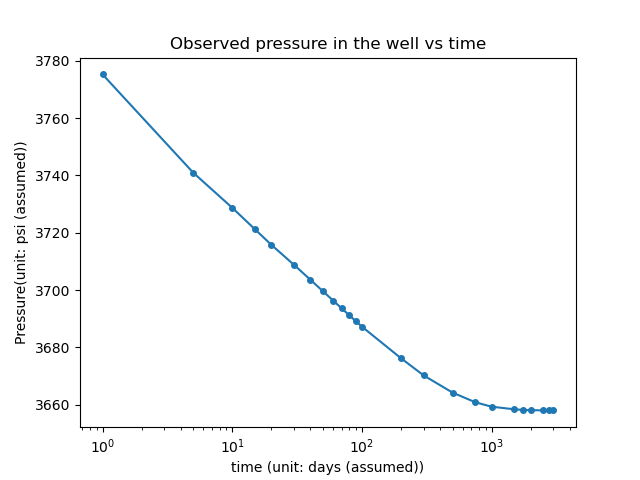

In [356]:
# read and plot well test data 
df = pd.read_csv('./data/well_bhp.dat', delimiter ='\t')
plt.plot(df.time, df.well_pressure, '-o', markersize=4)
plt.title('Observed pressure in the well vs time')
plt.xscale('log')
plt.xlabel('time (unit: days (assumed))')
plt.ylabel('Pressure(unit: psi (assumed))')
plt.savefig('Observeddata.png')

[3780. 3780. 3780. 3780.]


<IPython.core.display.Javascript object>


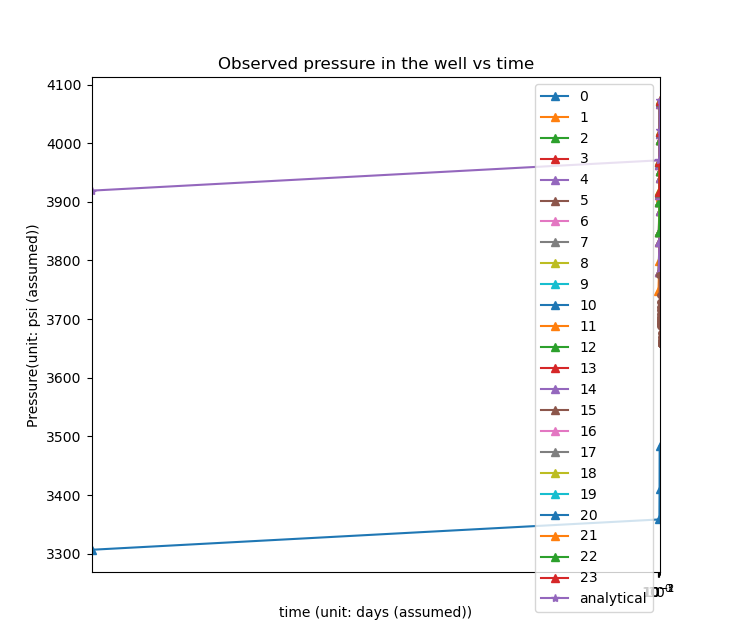

3281.023983138616
3721.4342865897543
3754.6656884003864
3754.6658535435276
3754.66583424699
3822.792063820166
3822.7922142533203
3822.7922308776238
3822.792230877664
3822.792230877664
3822.792214253726
3822.7922308776238
3822.792197629778
3886.0854510852673
3886.0854675420483
3889.6585646859085
3890.3739134161815
3890.373914036257
3891.8053414130004
3890.3739130785575
3890.3739151352165
3891.8053408631463
3890.3739174744055
3890.373911838332


In [353]:
tgiven= np.array(df.time )
t = np.append([0],tgiven)
deltat = t[1:]-t[:-1]
N=4
dt=deltat[0]
pn=pinit*np.ones(N)
print(pn)
fig, ax = plt.subplots()
x=np.array([0,1,2,3])

for i,dt in enumerate(deltat[:]):
    
    model = PressureSolver(N,dt, pn)
    model.solve_timedep()
    model.find_well_pressure(model.pn1[0])
    pn= model.pn1_psi
    print(model.pw_psi)
    ax.plot(x+i*0.02,pn, '-^',label=i)
ax.plot(model.analytical_steadystate(model.y)/model.psi_to_pa_,'-*', label= 'analytical')
plt.legend()

In [331]:
pn = model.pn1_psi
dt=dt=deltat[1]
model = PressureSolver(N,dt, pn)
model.solve_timedep()
model.find_well_pressure(model.pn1[0])
model.pw_psi, model.pn1_psi

(3721.4342865897543,
 array([3747.27956859, 3798.97190463, 3850.764982  , 3908.2843705 ]))

In [332]:
pn = model.pn1_psi
dt=dt=deltat[2]
model = PressureSolver(N,dt, pn)
model.solve_timedep()
model.find_well_pressure(model.pn1[0])
model.pw_psi, model.pn1_psi

(3754.6656884003864,
 array([3780.5109704 , 3832.20296459, 3883.97625554, 3940.37003415]))

In [323]:
model.solve_timedep()

In [317]:
tgiven= np.array(df.time )
t = np.append([0],tgiven)
deltat = t[1:]-t[:-1]
N=4
k=300
pinit=3780.0
re=1000.0

wellpressure = []
pn = pinit*np.ones(N)
print('original', pn)
for dt in deltat:
    model = PressureSolver(N,dt, pn)
    model.solve_timedep()
    model.find_well_pressure(model.pn1[0])
    wellpressure.append(model.pw_psi)
    pn = model.pn1_psi
    print('pressure*',pn)

original [3780. 3780. 3780. 3780.]
pressure* [3306.86926514 3358.56608398 3410.61914083 3482.95869623]
pressure* [3747.27956859 3798.97190463 3850.764982   3908.2843705 ]
pressure* [3780.5109704  3832.20296459 3883.97625554 3940.37003415]
pressure* [3780.51113555 3832.20312973 3883.97642058 3940.37019332]
pressure* [3780.51111625 3832.20311043 3883.97640129 3940.37017469]
pressure* [3848.63734582 3900.32863781 3952.06130084 4006.14470843]
pressure* [3848.63749626 3900.32878824 3952.06145117 4006.14485339]
pressure* [3848.63751288 3900.32880486 3952.06146779 4006.14486944]
pressure* [3848.63751288 3900.32880486 3952.06146779 4006.14486944]
pressure* [3848.63751288 3900.32880486 3952.06146779 4006.14486944]
pressure* [3848.63749626 3900.32878824 3952.06145117 4006.14485339]
pressure* [3848.63751288 3900.32880486 3952.06146779 4006.14486944]
pressure* [3848.63747963 3900.32877161 3952.06143456 4006.14483734]
pressure* [3911.93073309 3963.62137109 4015.31621333 4067.2498925 ]
pressure* [39

In [319]:
wellpressure

[3281.023983138616,
 3721.4342865897543,
 3754.6656884003864,
 3754.6658535435276,
 3754.66583424699,
 3822.792063820166,
 3822.7922142533203,
 3822.7922308776238,
 3822.792230877664,
 3822.792230877664,
 3822.792214253726,
 3822.7922308776238,
 3822.792197629778,
 3886.0854510852673,
 3886.0854675420483,
 3889.6585646859085,
 3890.3739134161815,
 3890.373914036257,
 3891.8053414130004,
 3890.3739130785575,
 3890.3739151352165,
 3891.8053408631463,
 3890.3739174744055,
 3890.373911838332]

In [289]:
%matplotlib notebook

In [313]:
# at time 0
day_to_sec_ = 24.*60.*60.




N = 4

def func_to_optimize(deltat, k, pinit, re):
    wellpressure = []
    pn = pinit*np.ones(N)
    for dt in deltat:
        
        model = PressureSolver(N,dt, pn, k=k,pinit=pinit, re=re)
        model.solve_timedep()
        model.find_well_pressure(model.pn1[0])
        wellpressure.append(model.pw_psi)
        pn = model.pn1_psi
        print('pressure*',pn)
        
    return(wellpressure)




#p = func_to_optimize(deltat, k, pinit, re)
func_to_optimize(deltat, *popt)

pressure* [3685.18422781 3692.42995964 3699.67569174 3706.92142412]
pressure* [3685.18422945 3692.42996107 3699.67569277 3706.92142454]
pressure* [3685.18422956 3692.42996117 3699.67569284 3706.92142456]
pressure* [3685.18422956 3692.42996117 3699.67569284 3706.92142456]
pressure* [3685.18422956 3692.42996117 3699.67569284 3706.92142456]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422978 3692.42996136 3699.67569298 3706.92142462]
pressure* [3685.18422997 3692.42996153 3699.6756931  3706.92142467]
pressure* [3685.18422997 3692.42996153 3699.6756

[3681.5613620311447,
 3681.561363667849,
 3681.5613637769643,
 3681.561363776964,
 3681.561363776963,
 3681.561363995191,
 3681.5613639951907,
 3681.5613639951903,
 3681.5613639951916,
 3681.5613639951903,
 3681.5613639951907,
 3681.5613639951903,
 3681.561363995192,
 3681.561364191595,
 3681.5613641915947,
 3681.5613642025073,
 3681.56136420469,
 3681.5613642046883,
 3681.561364209055,
 3681.5613642046906,
 3681.5613642046897,
 3681.561364209052,
 3681.5613642046897,
 3681.56136420469]

<IPython.core.display.Javascript object>


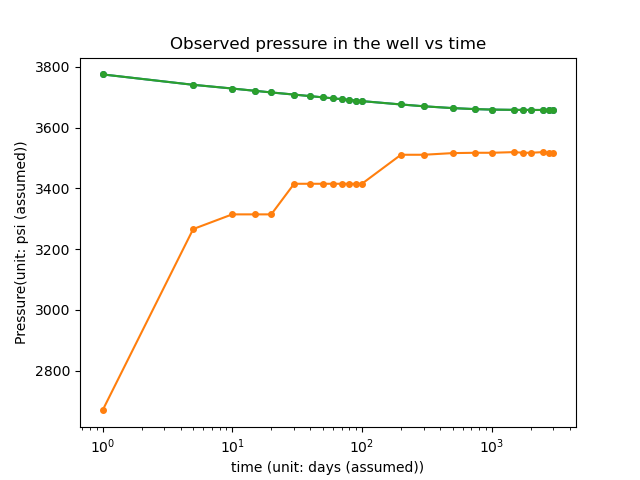

In [306]:
# read and plot well test data 
df = pd.read_csv('./data/well_bhp.dat', delimiter ='\t')
plt.plot(df.time, df.well_pressure, '-o', markersize=4)
plt.plot(df.time, p, '-o', markersize=4)

plt.title('Observed pressure in the well vs time')

plt.xlabel('time (unit: days (assumed))')
plt.ylabel('Pressure(unit: psi (assumed))')
plt.savefig('Observeddata.png')

In [308]:
xdata = deltat
ydata = np.array(df.well_pressure)
func=func_to_optimize
popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000)

pressure* [-12867.43746018  -9190.67113243  -5513.96028696  -1837.30846937]
pressure* [-12867.73597222  -9190.93679021  -5514.15147716  -1837.38091946]
pressure* [-12867.75586978  -9190.95449786  -5514.16422112  -1837.38574869]
pressure* [-12867.75586979  -9190.95449786  -5514.16422113  -1837.38574869]
pressure* [-12867.75586978  -9190.95449785  -5514.16422112  -1837.38574869]
pressure* [-12867.79566513  -9190.98991336  -5514.1897092   -1837.39540722]
pressure* [-12867.79566512  -9190.98991335  -5514.18970919  -1837.39540722]
pressure* [-12867.79566513  -9190.98991336  -5514.1897092   -1837.39540722]
pressure* [-12867.79566513  -9190.98991336  -5514.1897092   -1837.39540722]
pressure* [-12867.79566513  -9190.98991336  -5514.1897092   -1837.39540722]
pressure* [-12867.79566512  -9190.98991335  -5514.18970919  -1837.39540722]
pressure* [-12867.79566513  -9190.98991336  -5514.1897092   -1837.39540722]
pressure* [-12867.79566511  -9190.98991334  -5514.18970919  -1837.39540721]
pressure* [-

pressure* [3407.82490117 3969.97830841 4532.13172478 5094.28516099]
pressure* [3407.82481296 3969.97822432 4532.13165395 5094.28512324]
pressure* [3407.82481296 3969.97822432 4532.13165395 5094.28512324]
pressure* [3407.82490117 3969.97830841 4532.13172478 5094.28516099]
pressure* [3407.82481296 3969.97822432 4532.13165395 5094.28512324]
pressure* [3407.82481296 3969.97822432 4532.13165395 5094.28512324]
pressure* [3407.78091482 3969.93637055 4532.096393   5094.26633136]
pressure* [3407.81399224 3969.96790228 4532.12295406 5094.2804849 ]
pressure* [3407.81619753 3969.97000451 4532.12472488 5094.2814285 ]
pressure* [3407.81619753 3969.97000451 4532.12472488 5094.2814285 ]
pressure* [3407.81619753 3969.97000451 4532.12472488 5094.2814285 ]
pressure* [3407.82060811 3969.97420897 4532.12826653 5094.28331571]
pressure* [3407.82060811 3969.97420897 4532.12826653 5094.28331571]
pressure* [3407.82060811 3969.97420897 4532.12826653 5094.28331571]
pressure* [3407.82060811 3969.97420897 4532.1282

pressure* [3609.56880277 3768.108442   3926.64808193 4085.18772273]
pressure* [3609.56880277 3768.108442   3926.64808193 4085.18772273]
pressure* [3609.56880552 3768.10844448 3926.64808379 4085.18772352]
pressure* [3609.56880277 3768.108442   3926.64808193 4085.18772273]
pressure* [3609.56880277 3768.108442   3926.64808193 4085.18772273]
pressure* [3609.56748608 3768.10726536 3926.64721773 4085.18738642]
pressure* [3609.56851806 3768.10819367 3926.64791254 4085.1876855 ]
pressure* [3609.56858686 3768.10825555 3926.64795886 4085.18770544]
pressure* [3609.56858686 3768.10825555 3926.64795886 4085.18770544]
pressure* [3609.56858686 3768.10825555 3926.64795886 4085.18770544]
pressure* [3609.56872446 3768.10837933 3926.64805151 4085.18774532]
pressure* [3609.56872446 3768.10837933 3926.64805151 4085.18774532]
pressure* [3609.56872446 3768.10837933 3926.64805151 4085.18774532]
pressure* [3609.56872446 3768.10837933 3926.64805151 4085.18774532]
pressure* [3609.56872446 3768.10837933 3926.6480

pressure* [3650.62758267 3727.00776739 3803.38795225 3879.76813727]
pressure* [3650.62731409 3727.00752851 3803.38777743 3879.76806479]
pressure* [3650.62751933 3727.00771053 3803.38791036 3879.76811979]
pressure* [3650.62753301 3727.00772267 3803.38791922 3879.76812346]
pressure* [3650.62753301 3727.00772267 3803.38791922 3879.76812346]
pressure* [3650.62753301 3727.00772267 3803.38791922 3879.76812346]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62756038 3727.00774694 3803.38793694 3879.76813079]
pressure* [3650.62758501 3727.00776878 3803.3879

pressure* [3679.24555967 3698.37382008 3717.50208089 3736.63034209]
pressure* [3679.24555967 3698.37382008 3717.50208089 3736.63034209]
pressure* [3679.24555967 3698.37382008 3717.50208089 3736.63034209]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556122 3698.37382145 3717.50208187 3736.63034249]
pressure* [3679.24556262 3698.37382267 3717.50208275 3736.63034284]
pressure* [3679.24556262 3698.37382267 3717.50208275 3736.63034284]
pressure* [3679.24556269 3698.37382274 3717.50208279 3736.63034286]
pressure* [3679.24556271 3698.37382275 3717.5020

In [309]:
popt

array([7.35947707e+00, 3.71054429e+03, 3.23328079e-01])

In [235]:
k=500
pinit=3000.0
re=1000.0
p = func_to_optimize(deltat, k, pinit, re)

array([  1.00000003,   3.99999989,   4.99999992,   5.00000016,
         4.99999944,  10.00000056,   9.9999984 ,  10.0000008 ,
        10.0000008 ,  10.0000008 ,   9.9999984 ,  10.0000008 ,
         9.999996  ,  99.999996  , 100.000008  , 200.000016  ,
       249.999984  , 250.000032  , 499.999968  , 249.999936  ,
       250.000128  , 499.999776  , 250.00032   , 249.99984   ])

In [229]:
# at time 0

tgiven= np.array(df.time )
t = np.append([0],np.array(df.time ))
deltat = t[1:]-t[:-1]
deltat

def func_to_optimize(deltat, k, pinit, re):
    wellpressure = []
    pn = None
    for dt in deltat:
        model = PressureSolver(10,dt, pn, k=k,pinit=pinit, re=re)
        model.solve_timedep()
        model.find_well_pressure(model.pn1[0])
        wellpressure.append(model.pw_psi)
        pn = model.pn1_psi
    return(wellpressure)


In [228]:
xdata = deltat
ydata = np.array(df.well_pressure)
func=func_to_optimize
popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000)

In [ ]:
# at time 1


In [ ]:
def func_to_optimize():
    

In [213]:
a = np.array([1,2,3])
a is None

False

In [212]:
len(None)

TypeError: object of type 'NoneType' has no len()

In [201]:
a =[1]
b = [2,3,4]
np.append(a,b)

array([1, 2, 3, 4])

In [174]:
a = np.linspace(0,10,11)
a[1:]-a[:-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [178]:
a = [1,2,3]
if not a:
    print('a value is none')
else:
    print('a value is ', a)

a value is  [1, 2, 3]


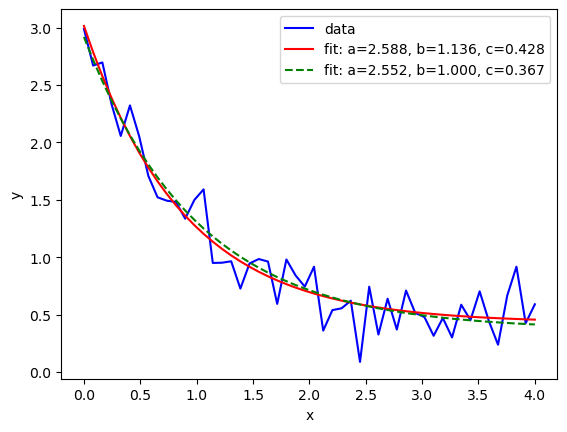

In [161]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [159]:
t = df.time
t

0        1.000000
1        5.000000
2       10.000000
3       15.000000
4       19.999999
5       30.000000
6       39.999998
7       49.999999
8       60.000000
9       70.000001
10      79.999999
11      90.000000
12      99.999996
13     199.999992
14     300.000000
15     500.000016
16     750.000000
17    1000.000032
18    1500.000000
19    1749.999936
20    2000.000064
21    2499.999840
22    2750.000160
23    3000.000000
Name: time, dtype: float64

In [146]:
df

,time,well_pressure
0,1.000000,3775.204835
1,5.000000,3740.949470
2,10.000000,3728.708408
3,15.000000,3721.164836
4,19.999999,3715.811339
5,30.000000,3708.776561
6,39.999998,3703.638589
7,49.999999,3699.627128
8,60.000000,3696.351880
9,70.000001,3693.591952


In [139]:
model = PressureSolver(4,0.01)
model.make_equations()

In [140]:
model.A

array([[ 5.28702460e+03, -5.28602460e+03,  0.00000000e+00,
         0.00000000e+00],
       [-9.42633218e+01,  1.89526644e+02, -9.42633218e+01,
         0.00000000e+00],
       [ 0.00000000e+00, -1.68095582e+00,  4.36191165e+00,
        -1.68095582e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.99757363e-02,
         1.08992721e+00]])

In [155]:
model.pinit_

28268504.889

The model i made and the solution provided is off by a small amount in the y coordinate. i cant figure out why


In [130]:
solution = np.array([5.28602460e3, 9.42633218e1, 1.68095582e0, 2.99757363e-02])

In [99]:
y = model.y
model.maxy, y

(8.053459175184097, array([1.0066824 , 3.02004719, 5.03341198, 7.04677678]))

In [131]:
model = PressureSolver(4,0.01)

In [132]:
model.make_equations()
model.A

array([[ 5.31488239e+03, -5.31388239e+03,  0.00000000e+00,
         0.00000000e+00],
       [-9.47600974e+01,  1.90520195e+02, -9.47600974e+01,
         0.00000000e+00],
       [ 0.00000000e+00, -1.68981460e+00,  4.37962920e+00,
        -1.68981460e+00],
       [ 0.00000000e+00,  0.00000000e+00, -3.01337110e-02,
         1.09040113e+00]])

In [133]:
model.xi/np.exp(-2*y)

array([39792.86039121, 39792.86039121, 39792.86039121, 39792.86039121])

In [134]:
-np.log((solution/39792.86039121))/2

array([1.00931052, 3.02267531, 5.03604011, 7.0494049 ])

In [135]:
solutiony = -np.log((solution/39792.86039121))/2
solutiony

array([1.00931052, 3.02267531, 5.03604011, 7.0494049 ])

In [123]:
model.dy/0.00262812

766.0855645084791

In [113]:
solutiony-model.y

array([0.00262812, 0.00262812, 0.00262812, 0.00262812])

In [136]:
solutiony

array([1.00931052, 3.02267531, 5.03604011, 7.0494049 ])

In [137]:
model.y

array([1.0066824 , 3.02004719, 5.03341198, 7.04677678])

In [104]:
np.exp(-2*y)

array([1.33538588e-01, 2.38133415e-03, 4.24652710e-05, 7.57264260e-07])